# Insight Is Everywhere.

Data Science is not reserved for those people who have formally trained in it. Anyone with the motivation can hop on their laptop and start digging, investigating, and visualising.

They can get started on the data they have lying around. And boy, do we have it lying around - often in very large quantities. In our jobs and in our lives, we are constantly chucking out data - and although the quality of it varies from source to source, I simply will not believe you if you tell me that there's nothing of value that can be drawn out from the data you have access to.

I wanted to demonstrate that it is fully possible to gain insight even from simple data sources that you may initially overlook. In certain sectors, such as finance, there is typically no shortage of numerical data to analyse - but I appreciate that this may not be the case in other industries. So, to show that these principles apply more generally in other types of organisation, we're going to forgo the numbers and investigate a rather generic data file.

### Import data

In [721]:
# Import modeules for data manipulation, maths, and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read in data
wip = pd.read_csv("Data/fictional_wip.csv")

# Convert the columns containing dates to datetime objects to make them more agreeable to work with
wip_datecols = ["Date requested", "Deadline", "Date sent"]

for wip_datecol in wip_datecols:
    wip[wip_datecol] = pd.to_datetime(wip[wip_datecol], format="%d/%m/%Y")

In [722]:
# Inspect first few rows of WIP data
wip.head()

,Member name,Calculation type,Date requested,Deadline,Done by,Checked by,Reviewed by,Date sent,Size,Deadline met?
0,David Davidson,Transfer value,2019-01-05,2019-01-09,Alice,Bob,Dave,2019-01-07,367120.0,Y
1,John Johnson,Retirement quote,2019-01-06,2019-01-08,Alice,Bob,Dave,2019-01-08,15383.0,Y
2,Paul Paulson,Transfer value,2019-01-09,2019-01-11,Alice,Bob,Dave,2019-01-11,309297.0,Y
3,Mark Markson,Transfer value,2019-01-13,2019-01-17,Alice,Bob,Dave,2019-01-16,27729.0,Y
4,James Jamesson,Retirement quote,2019-01-16,2019-01-18,Alice,Bob,Carol,2019-01-17,5989.0,Y


### Data dictionary

- Member name: name of member
- Calculation type: type of calculation requetsed by member or scheme administrator
- Date requested: date on which the work was requested
- Deadline: date that the administrators require the calculation to be returned by
- Done by: staff member who performed the calculation
- Checked by: staff member who checked the calculation, once it had been done
- Reviewed by: staff member who reviewed and approved the calculation to be sent out, once it had been checked
- Date sent: date that the calculation was issued 
- Size: where applicable, the size of the transfer value (in £) or retirement quote (in £ per annum)
- Deadline met?: whether the calculation was sent out before or on the date of the given deadline

### Address missing values

In [616]:
# Check for missing values
wip.isna().sum()

Member name          0
Calculation type     0
Date requested       0
Deadline             0
Done by              0
Checked by           0
Reviewed by          1
Date sent            0
Size                15
Deadline met?        0
dtype: int64

There appear to be 16 missing values, 15 of which are in the Size column and one of which is in the Reviewed By column.  Let's inspect further:

In [723]:
wip[wip["Size"].isna()]

,Member name,Calculation type,Date requested,Deadline,Done by,Checked by,Reviewed by,Date sent,Size,Deadline met?
7,Steven Stevenson,Pension sharing order,2019-01-27,2019-01-31,Alice,Carol,Dave,2019-02-04,NaN,N
9,Stephen Stephenson,Augmentation,2019-02-09,2019-02-11,Alice,Bob,Carol,2019-02-11,NaN,Y
11,Craig Craigson,Augmentation,2019-02-14,2019-02-17,Bob,Alice,Dave,2019-02-17,NaN,Y
14,Christopher Christopherson,Augmentation,2019-02-26,2019-02-28,Alice,Bob,Carol,2019-03-02,NaN,N
16,Colin Colinson,LRF calculation,2019-03-11,2019-03-14,Alice,Bob,Carol,2019-03-13,NaN,Y
24,Neil Neilson,Pension sharing order,2019-05-04,2019-05-09,Alice,Bob,Carol,2019-05-10,NaN,N
25,Barry Barryson,Augmentation,2019-05-05,2019-05-10,Alice,Carol,Dave,2019-05-07,NaN,Y
36,Kenneth Kennethson,Augmentation,2019-06-11,2019-06-16,Alice,Bob,Dave,2019-06-19,NaN,N
44,Ross Rossson,Augmentation,2019-08-06,2019-08-10,Eve,Alice,Bob,2019-08-09,NaN,Y
45,Jonathan Jonathanson,LRF calculation,2019-08-07,2019-08-09,Eve,Alice,Carol,2019-08-10,NaN,N


It seems like the Size for these calcaultions is either not applicable or has not been recorded.  We do not have a representative sample for the sizes of Augmentations or PSO cases, so we shouln't try to impute values.  

However, there are no Transfer Value or Retirement Quote calculations in this list, which implies that we have complete data for these types of calculations.  We should be able to do some good descriptive analysis for these types of calculations.

In [724]:
wip[wip["Reviewed by"].isna()]

,Member name,Calculation type,Date requested,Deadline,Done by,Checked by,Reviewed by,Date sent,Size,Deadline met?
61,Arianna Ariannason,Transfer value,2019-11-21,2019-11-25,Eve,Alice,NaN,2019-11-24,63320.0,Y


Looks like this row hasn't been filled out completely and is just missing an entry.  We could try to impute the missing value from our non-misisng data, or we could drop the row completely.  However, since it's just one row, we could also look back on our records and see if we can fill in the data ourselves.  

Looking at the records, this case was reviewed by Carol.  Let's fill this in.

In [725]:
# Replace missing value in Reviewed By column with "Carol"
wip["Reviewed by"].fillna("Carol", inplace=True)

# Check that this has had the desired effect
wip.loc[61,]

Member name          Arianna Ariannason
Calculation type         Transfer value
Date requested      2019-11-21 00:00:00
Deadline            2019-11-25 00:00:00
Done by                             Eve
Checked by                        Alice
Reviewed by                       Carol
Date sent           2019-11-24 00:00:00
Size                              63320
Deadline met?                         Y
Name: 61, dtype: object

### Who's been doing what?

Let's analyse how Alice and Bob have been involved in these tasks over time.

In [727]:
# Identify cases Alice and Bob involved in
wip["alice_involved"] = (wip["Done by"] == "Alice") | (wip["Checked by"] == "Alice") | (wip["Reviewed by"] == "Alice")
wip["bob_involved"] = (wip["Done by"] == "Bob") | (wip["Checked by"] == "Bob") | (wip["Reviewed by"] == "Bob")

# Create new representation of Date sent column to help with plotting later
wip["sent_date_yyyymm"] = wip["Date sent"].map(lambda x: x.year*100 + x.month) 

# Take the subsets of cases Alice and Bob have been involved in
alice_wip = wip[wip["alice_involved"]].copy()
bob_wip = wip[wip["bob_involved"]].copy()

# We want to add a new column identifying which roles Alice and Bob had in each case.  
# Define empty lists to hold this information, which will then be added to our dataframes 
alice_roles = []
bob_roles = []

# Go through each row of alice_wip identifying Alice's role
for row in alice_wip.iterrows():
    if row[1][4] == "Alice":
        alice_roles.append("Done")
    elif row[1][5] == "Alice":
        alice_roles.append("Checked")

# Add the new column
alice_wip["alice_role"] = alice_roles

# Repeat process for Bob
bob_roles = []

for row in bob_wip.iterrows():
    if row[1][4] == "Bob":
        bob_roles.append("Done")
    elif row[1][5] == "Bob":
        bob_roles.append("Checked")
    elif row[1][6] == "Bob":
        bob_roles.append("Reviewed")
        
bob_wip["bob_role"] = bob_roles

In [729]:
# Manipulate dataframes into a useful form for plotting by grouping
# Group by sent date and identify how many times Alice and Bob had each role in the work process
alice_data = alice_wip.groupby(["sent_date_yyyymm", "alice_role"]).size().unstack()
bob_data = bob_wip.groupby(["sent_date_yyyymm", "bob_role"]).size().unstack()

# Replace NaNs with zeroes, as these indicate Alice or bob did not perform that role at all in a given month 
alice_data.fillna(0, inplace=True)
bob_data.fillna(0, inplace=True)

alice_data

alice_role,Checked,Done
sent_date_yyyymm,,
201901,0.0,8.0
201902,1.0,5.0
201903,0.0,4.0
201904,0.0,5.0
201905,2.0,9.0
201906,2.0,3.0
201907,2.0,1.0
201908,6.0,1.0
201909,2.0,0.0


In [730]:
bob_data

bob_role,Checked,Done,Reviewed
sent_date_yyyymm,,,
201901,6.0,0.0,1.0
201902,3.0,1.0,0.0
201903,4.0,0.0,0.0
201904,2.0,0.0,0.0
201905,5.0,2.0,1.0
201906,2.0,2.0,1.0
201907,1.0,0.0,2.0
201908,0.0,0.0,4.0
201909,0.0,0.0,2.0


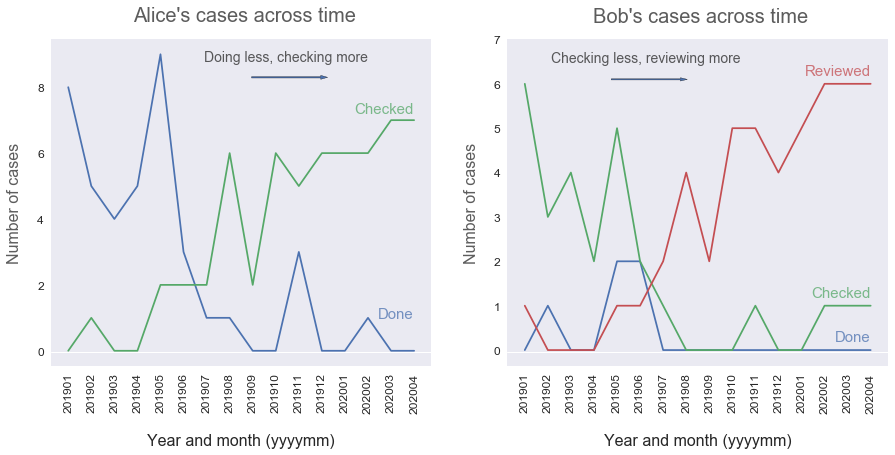

In [732]:
# Set style of plotting area
import matplotlib.style as style
style.use('seaborn')

# Set up plotting area - we're going to have two plots side-by-side
fig = plt.figure(figsize=(15,6))



# --- FIRST PLOT ---

# Add left subplot within plotting area
ax1 = fig.add_subplot(121)

# Plot alice_data
p1 = ax1.plot(np.arange(16) + 0.75, alice_data["Done"].values)
p2 = ax1.plot(np.arange(16) + 0.75, alice_data["Checked"].values)

# Add x ticks
plt.xticks(np.arange(0,16) + 0.75, fontsize=10, rotation=90)
ax1.set_xticklabels(alice_data.index)

# Set font sizes for tick labels
ax1.tick_params(axis="x", labelsize=12)
ax1.tick_params(axis="y", labelsize=12)

# Make the zero line more visible
plt.axhline(y=-0.05, xmin=0, xmax=1, color="white", linewidth=1)

# Add x label
ax1.set_xlabel("Year and month (yyyymm)", labelpad=20, fontsize=16)

# Add y label
ax1.set_ylabel("Number of cases", alpha = .75, labelpad=15, fontsize=16)

# Remove gridlines
ax1.grid(False)

# Add title
ax1.text(x = 8+.75/2, y = 10, s = "Alice's cases across time", fontsize = 20, alpha = .75, ha="center")

# Label lines
ax1.text(x = 15.75, y = 1, s = "Done",
            fontsize = 15, alpha = .75, ha="right", color=p1[0].get_color())
ax1.text(x = 15.75, y = 7.22, s = "Checked",
            fontsize = 15, alpha = .75, ha="right", color=p2[0].get_color())

# Add text and arrow to highlight trend
ax1.text(x = 10.2, y = 8.8, s = "Doing less, checking more",
            fontsize = 14, alpha = .75, ha="center")
ax1.arrow(8.7, 8.3, 3, 0, width=0.04, head_length=0.3)



# --- SECOND PLOT ---

# Add right subplot within plotting area
ax2 = fig.add_subplot(122)

# Plot bob_data
p3 = ax2.plot(np.arange(16) + 0.75, bob_data["Done"].values)
p4 = ax2.plot(np.arange(16) + 0.75, bob_data["Checked"].values)
p5 = ax2.plot(np.arange(16) + 0.75, bob_data["Reviewed"].values)

# Add x ticks
plt.xticks(np.arange(0,16) + 0.75, fontsize=10, rotation=90)
ax2.set_xticklabels(bob_data.index)

# Set font sizes for tick labels
ax2.tick_params(axis="x", labelsize=12)
ax2.tick_params(axis="y", labelsize=12)

# Make the zero line more visible
plt.axhline(y=-0.05, xmin=0, xmax=1, color="white", linewidth=1)

# Add x label
ax2.set_xlabel("Year and month (yyyymm)", labelpad=20, fontsize=16)

# Add y label
ax2.set_ylabel("Number of cases", alpha = .75, labelpad=15, fontsize=16)

# Set limits on y-axis
ax2.set_ylim(-0.35,7)

# Remove gridlines
ax2.grid(False)

# Add title
ax2.text(x = 8+.75/2, y = 7.39, s = "Bob's cases across time", fontsize = 20, alpha = .75, ha="center")

# Label lines
ax2.text(x = 15.75, y = 0.2, s = "Done",
            fontsize = 15, alpha = .75, ha="right", color=p3[0].get_color())
ax2.text(x = 15.75, y = 1.2, s = "Checked",
            fontsize = 15, alpha = .75, ha="right", color=p4[0].get_color())
ax2.text(x = 15.75, y = 6.2, s = "Reviewed",
            fontsize = 15, alpha = .75, ha="right", color=p5[0].get_color())

# Add text and arrow to highlight trend
ax2.text(x = 6, y = 6.5, s = "Checking less, reviewing more",
            fontsize = 14, alpha = .75, ha="center")
ax2.arrow(4.5, 6.1, 3, 0, width=0.025, head_length=0.3)

### Have we been meeting deadlines?

We're likely to have some sort of service level agreement in place to ensure that we're doing our work quickly enough. Delivering below the agreed level of service will damage our relationships with our clients. We could end up losing business if they end up going to one of our competitors instead in search of better service.  With that in mind, let's look at whether we've been hitting our deadlines lately.

In [734]:
# Group our data by whether or not we hit the deadline.  Then, slice it up by month
deadline_data = wip.groupby(["sent_date_yyyymm", "Deadline met?"]).size().unstack()

# Fill in missing values.  Missing values mean we had no cases in that particular month, so replace with zeroes
deadline_data.fillna(0, inplace=True)

# Calculate percentage of cases delivered on time in each month
deadline_data["total_cases"] = deadline_data["N"] + deadline_data["Y"]
deadline_data["percent_on_time"] = deadline_data["Y"] * 100 / deadline_data["total_cases"]
deadline_data = deadline_data.astype("int")

deadline_data

Deadline met?,N,Y,total_cases,percent_on_time
sent_date_yyyymm,,,,
201901,0,8,8,100
201902,1,5,6,83
201903,1,3,4,75
201904,0,5,5,100
201905,2,9,11,81
201906,1,4,5,80
201907,1,2,3,66
201908,4,3,7,42
201909,1,1,2,50


In [ ]:
# --- SECOND PLOT ---

# Add right subplot within plotting area

# Plot bob_data

# Add x ticks

# Set font sizes for tick labels

# Make the zero line more visible

# Add x label

# Add y label

# Set ylim

# Remove gridlines

# Add title

# Label lines

# Add text and arrow to highlight trend


Text(8.375, 80, '?')

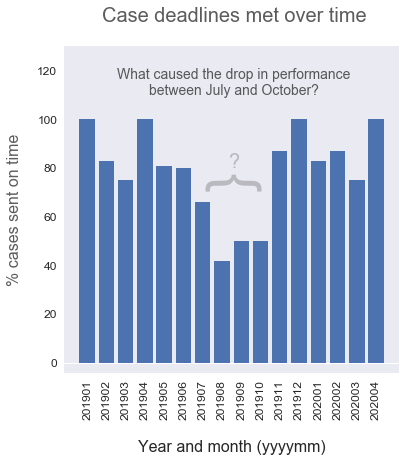

In [737]:
# Set up plotting area
fig, ax = plt.subplots(figsize=(6,6))

# Plot deadline_data
p1 = ax.bar(np.arange(16) + 0.75, deadline_data["percent_on_time"].values)

# Add x ticks
plt.xticks(np.arange(0,16) + 0.75, fontsize=10, rotation=90)
ax.set_xticklabels(deadline_data.index)

# Set font sizes for tick labels
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

# Make the zero line more visible
plt.axhline(y=-0.05, xmin=0, xmax=1, color="white", linewidth=1)

# Add x label
ax.set_xlabel("Year and month (yyyymm)", labelpad=20, fontsize=16)

# Add y label
ax.set_ylabel("% cases sent on time", alpha = .75, labelpad=15, fontsize=16)

# Remove gridlines
ax.grid(False)

# Add title
ax.text(x = 8+.75/2, y = 140, s = "Case deadlines met over time", fontsize = 20, alpha = .75, ha="center")

# Set limits on y-axis
ax.set_ylim(-4,130)

# Add text and highlight trend in data
ax.text(x = 8+.75/2, y = 110, s = "What caused the drop in performance\nbetween July and October?",
            fontsize = 14, alpha = .75, ha="center")
ax.text(x = 7.8+.75/2, y = 75, s = "{",
            fontsize = 60, alpha = .25, ha="center", rotation=270)
ax.text(x = 8+.75/2, y = 80, s = "?",
            fontsize = 20, alpha = .25, ha="center")

Looks like we generally maintain a service level of delivering between 80% and 100% of cases on time. However, there's a pretty significant drop in service level from July to October 2019. If we're not already aware, we'll want to drill down into why our team wasn't performing as well and address the issue. Were we understaffed? Was it a particularly busy period? Do we need to hire more permanent or temporary staff to cope?

### What cases are we missing deadlines for?

Hitting deadlines is important for our team and for our relationship with our clients.  Let's take a look at the kind of cases where we're not performing as well as we should be. 

In [637]:
missed_cases = wip[wip["Deadline met?"] == "N"].copy()

data4 = missed_cases["Calculation type"].value_counts().to_frame()

data4["%"] = data4["Calculation type"] * 100 / data4["Calculation type"].sum()

data4["%"] = data4["%"].astype("int")

data4



,Calculation type,%
Transfer value,6,31
Retirement quote,5,26
Augmentation,3,15
LRF calculation,3,15
Pension sharing order,2,10


In [685]:
all_cases = wip["Calculation type"].value_counts().to_frame()
all_cases 

data4["Total cases"] = all_cases["Calculation type"]

data4["Total cases %"] = data4["Total cases"] * 100 / data4["Total cases"].sum()

data4["Total cases %"] = data4["Total cases %"].astype("int")

data4

,Calculation type,%,Total cases,Total cases %
Transfer value,6,31,59,58
Retirement quote,5,26,27,26
Augmentation,3,15,8,7
LRF calculation,3,15,4,3
Pension sharing order,2,10,3,2


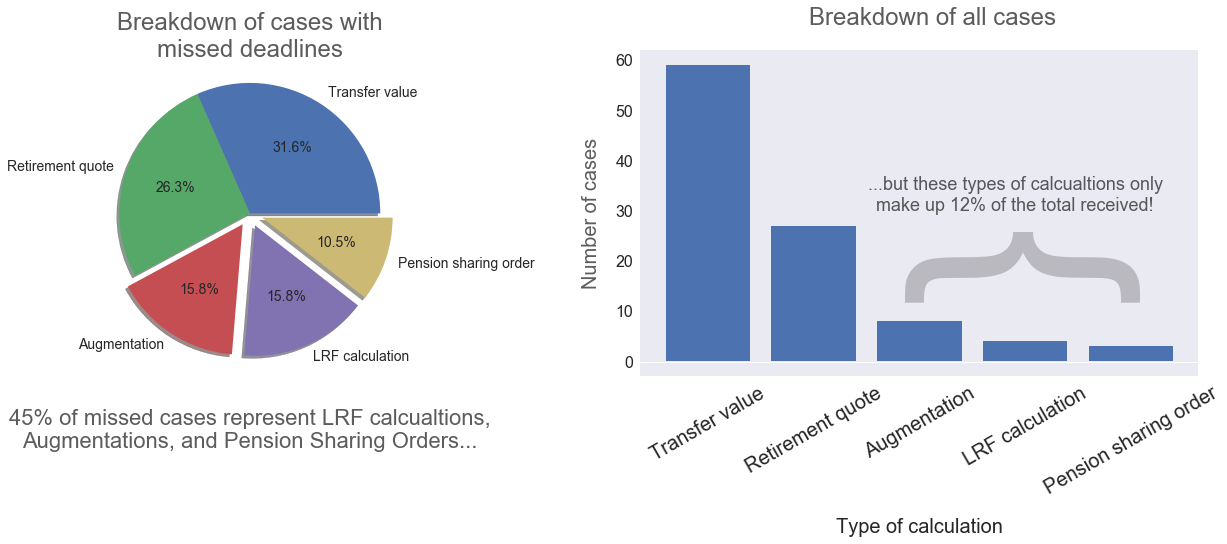

In [706]:
fig = plt.figure(figsize=(22,6))

ax1 = fig.add_subplot(121)

p1 = ax1.pie(data4["Calculation type"].values, explode=(0, 0,0.1,0.1,0.1), labels=data4.index,
            autopct='%1.1f%%', shadow=True, textprops={'fontsize': 14})


# Add title
ax1.text(x=0, y=1.2, s = "Breakdown of cases with\nmissed deadlines", fontsize = 24, alpha = .75, ha="center")

ax1.text(x=0, y = -1.8, s = "45% of missed cases represent LRF calcualtions,\nAugmentations, and Pension Sharing Orders...",
            fontsize = 22, alpha = .75, ha="center")

# ax1.arrow(8.7, 8.3, 3, 0, width=0.04, head_length=0.3)


ax2 = fig.add_subplot(122)

p2 = ax2.bar(np.arange(5) + 0.75, data4["Total cases"].values)

plt.xticks(np.arange(0,5) + 0.75, fontsize=16, rotation=30)

ax2.set_xticklabels(data4.index)

# Make the zero line more visible
plt.axhline(y=-0.05, xmin=0, xmax=1, color="white", linewidth=1)

# Add x label
ax2.set_xlabel("Type of calculation", labelpad=20, fontsize=20)

# Add y label
ax2.set_ylabel("Number of cases", alpha = .75, labelpad=15, fontsize=20)

# # Set ylim
# ax2.set_ylim(-0.35,7)

# Remove gridlines
ax2.grid(False)

# Add title
ax2.text(x = 2.5+0.75/2, y = 67, s = "Breakdown of all cases", fontsize = 24, alpha = .75, ha="center")

ax2.text(x = 3.655, y = 30, s = "...but these types of calcualtions only\nmake up 12% of the total received!",
            fontsize = 18, alpha = .75, ha="center")

ax2.text(x = 3.65, y = 20, s = "{",
            fontsize = 250, alpha = .25, ha="center", rotation=270)

ax2.tick_params(axis="x", labelsize=20)
ax2.tick_params(axis="y", labelsize=16)

# ax2.arrow(4.5, 6.1, 3, 0, width=0.025, head_length=0.3)

How has the number and type of case Andrew has done/checked change over time?  Show increased responsibility, new employee, can we show it on one graph? number of cases each person is involved with over each month?


How does the percentage of deadlines hit vary over time?  can we identify any time peroods where the clent team was struggling?  If so, we could look into what was going wrong and try to address the problem

Do certain cases take longer/do we fail to hit the deadline on certain cases more often than usual?  Perhaps we need additionsl training on these

Are there any trends in the size column?  Which sizes are most common for TVs/retirement quotes?



Go back into the data and insert trends - bit cheeky as we will know what we're looking for but can't use real client data and trends are based off of real world experience! 